# Bands Structure
For the source code, see [bands](https://workgraph-collections.readthedocs.io/en/latest/qe/module.html#workgraph_collections.ase.espresso.bands.bands_workgraph).

## Introduction

## Visualizing the WorkGraph Builder



In [1]:
from workgraph_collections.qe.bands import bands_workgraph
from aiida import load_profile
load_profile()

node = bands_workgraph.node()
node.to_html()

## Visualizing the WorkGraph

In [2]:
from workgraph_collections.qe.bands import bands_workgraph
from aiida import load_profile
load_profile()

wg = bands_workgraph(run_relax=True)
wg.to_html()

## Example: Silicon band structure
### Prepare the inputs and submit the workflow


In [3]:
from copy import deepcopy

from aiida import load_profile
from aiida.orm import Dict, Float, KpointsData, StructureData, load_code
from aiida_workgraph import WorkGraph
from ase.build import bulk

from workgraph_collections.qe.bands import bands_workgraph

load_profile()

atoms = bulk('Si')
structure_si = StructureData(ase=atoms)

pw_code = load_code('qe-7.2-pw@localhost')
scf_paras = {
    'CONTROL': {
        'calculation': 'scf',
    },
    'SYSTEM': {
        'ecutwfc': 30,
        'ecutrho': 240,
        'occupations': 'smearing',
        'smearing': 'gaussian',
        'degauss': 0.1,
    },
}
relax_paras = deepcopy(scf_paras)
relax_paras['CONTROL']['calculation'] = 'vc-relax'
bands_paras = deepcopy(scf_paras)
bands_paras['CONTROL']['calculation'] = 'bands'

kpoints = KpointsData()
kpoints.set_kpoints_mesh([3, 3, 3])

#
metadata = {
    'options': {
        'resources': {
            'num_machines': 1,
            'num_mpiprocs_per_machine': 1,
        },
    }
}

bands_inputs = {
    'relax': {
        'base': {
            'pw': {
                'parameters': Dict(relax_paras),
                'metadata': metadata,
            },
            'kpoints': kpoints,
        },
    },
    'scf': {
        'pw': {
            'parameters': Dict(scf_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
    'bands': {
        'pw': {
            'parameters': Dict(bands_paras),
            'metadata': metadata,
        },
        'kpoints': kpoints,
    },
}

wg = WorkGraph('Bands')
wg = bands_workgraph(
    structure=structure_si,
    code=pw_code,
    inputs=bands_inputs,
    pseudo_family='SSSP/1.3/PBEsol/efficiency',
    run_relax=True,
    bands_kpoints_distance=Float(0.1),
)
#------------------------- Submit the calculation -------------------
wg.submit(wait=True, timeout=300)


WorkGraph node created, PK: 54566


<WorkChainNode: uuid: 49cfb308-9c51-44b4-aa16-7757b525397c (pk: 54566) (aiida_workgraph.engine.workgraph.WorkGraphEngine)>

## Plot the band structure

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Dispersion (eV)'>)

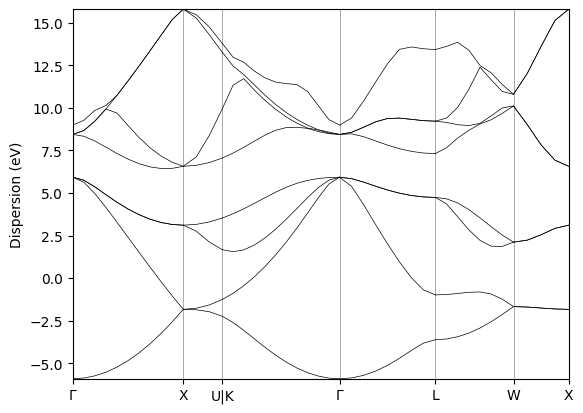

In [4]:
from workgraph_collections.qe.utils import plot_bandstructure
    
bands = wg.nodes["bands"].outputs["output_band"].value
plot_bandstructure(bands)